<a href="https://colab.research.google.com/github/heleownae/DA_Insurance_PJT/blob/main/%EA%B5%B0%EC%A7%91%ED%99%95%EC%9D%B8%EC%9A%A9%20eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#cos clustering, BPR 패키지 설치
!pip install soyclustering
!pip install implicit
!pip install koreanize-matplotlib
!pip install gower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import koreanize_matplotlib
from implicit.bpr import BayesianPersonalizedRanking
import plotly.express as px

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype
from scipy import sparse

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from soyclustering import SphericalKMeans
from soyclustering import visualize_pairwise_distance
from soyclustering import merge_close_clusters
from soyclustering import proportion_keywords



#warning 메시지 무시를 위한 코드
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종프/final_업권분류.csv')

In [ ]:
pd.set_option('display.max_colwidth', None)
df

,JOIN_SN,POL_SN,CT_RLPS_GBN_CD,GENDER,AGE,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_AMT,...,총지급 건수,기타,배책,사망/후유,수술/입원,실손,자동차,진단/통원,화재/재물,업권
0,15110,2197182,C,2,25,2,7,1,4,5000,...,0,0,0,0,0,0,0,0,0,2
1,56423,254040,C,2,28,2,1,1,1,170,...,0,0,0,0,0,0,0,0,0,2
2,1659127,5420542,C,2,46,4,7,1,5,180,...,0,0,0,0,0,0,0,0,0,0
3,817293,5884271,C,1,41,4,6,4,7,110,...,0,0,0,0,0,0,0,0,0,1
4,798115,6197631,C,1,54,5,3,1,1,50,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58422,1892963,8605817,C,1,36,3,6,4,7,10,...,0,0,0,0,0,0,0,0,0,1
58423,1898196,5285028,C,1,25,2,6,2,99,1,...,0,0,0,0,0,0,0,0,0,1
58424,1942749,6650657,C,1,24,2,6,4,7,6,...,0,0,0,0,0,0,0,0,0,1
58425,1946706,8536828,C,2,52,5,6,4,7,8,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_check = df[['JOIN_SN', 'POL_SN', 'GENDER','AGE_GROUP','reduce_GBN_CD', 'reduce_STAT_CD', 'CT_CHNL_CD','CT_PY_CYCLE_CD', 'CT_PY_PD', 'mean_AMT', 'GBN_CD_1', 'GBN_CD_2',
       'GBN_CD_3', 'GBN_CD_4' ,'업권' ]]

df_check

,JOIN_SN,POL_SN,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권
0,15110,2197182,2,2,7,1,4,1,0,5000.0,1,0,0,0,2
1,56423,254040,2,2,1,1,1,2,5,170.0,1,0,0,0,2
2,1659127,5420542,2,4,7,1,5,2,3,180.0,1,0,0,0,0
3,817293,5884271,1,4,6,4,7,1,0,110.0,1,0,0,1,1
4,798115,6197631,1,5,3,1,1,2,20,50.0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58422,1892963,8605817,1,3,6,4,7,1,0,10.0,1,0,0,1,1
58423,1898196,5285028,1,2,6,2,99,1,0,1.0,1,0,0,0,1
58424,1942749,6650657,1,2,6,4,7,1,0,6.0,1,0,0,1,1
58425,1946706,8536828,2,5,6,4,7,1,0,8.0,1,0,0,1,1


In [ ]:
df.columns

Index(['JOIN_SN', 'POL_SN', 'CT_RLPS_GBN_CD', 'GENDER', 'AGE', 'AGE_GROUP',
       'reduce_GBN_CD', 'reduce_STAT_CD', 'CT_CHNL_CD', 'CT_PY_AMT',
       'CT_PY_CYCLE_CD', 'CT_PY_PD', 'mean_AMT', 'GBN_CD_1', 'GBN_CD_2',
       'GBN_CD_3', 'GBN_CD_4', '총지급금액', '총지급 건수', '기타', '배책', '사망/후유', '수술/입원',
       '실손', '자동차', '진단/통원', '화재/재물', '업권'],
      dtype='object')

In [ ]:
df.drop(columns = ['CT_RLPS_GBN_CD','AGE','CT_PY_AMT'], axis=1 , inplace=True)

### 분석용 데이터프레임 만들기

In [ ]:
df_key = df[['JOIN_SN', 'POL_SN', 'mean_AMT','CT_CHNL_CD']]
df_al = df[['GENDER', 'AGE_GROUP','reduce_GBN_CD', 'reduce_STAT_CD', 'CT_PY_CYCLE_CD', 'GBN_CD_1', 'GBN_CD_2',
       'GBN_CD_3', 'GBN_CD_4','업권']]
df_al
df_al2 = df_al.copy()

#1-2 연속형범주들 standard 스케일링

In [ ]:
st = StandardScaler()
st = pd.DataFrame(st.fit_transform(df[['CT_PY_PD', 'mean_AMT']]),columns =('CT_PY_PDmm', 'mean_AMTmm'))
st

df_al2 = pd.concat([df_al,st], axis =1 )

sparse_matrix = sparse.csr_matrix(df_al2)

spherical_kmeans = SphericalKMeans(
    n_clusters=80,
    max_iter=120
  ,
    verbose=1,
    init='similar_cut',
    random_state=9
)

labels = spherical_kmeans.fit_predict(sparse_matrix)

centers = spherical_kmeans.cluster_centers_
keywords = proportion_keywords(centers, labels)


initialization_time=0.083228 sec, sparsity=0.87
n_iter=1, changed=57352, inertia=1283.235, iter_time=2.697 sec, sparsity=0.986
n_iter=2, changed=12077, inertia=853.612, iter_time=0.902 sec, sparsity=0.99
n_iter=3, changed=5728, inertia=783.670, iter_time=0.531 sec, sparsity=0.988
n_iter=4, changed=3267, inertia=762.544, iter_time=0.534 sec, sparsity=0.985
n_iter=5, changed=2284, inertia=747.871, iter_time=0.530 sec, sparsity=0.989
n_iter=6, changed=1440, inertia=740.105, iter_time=0.539 sec, sparsity=0.988
n_iter=7, changed=1310, inertia=735.645, iter_time=0.523 sec, sparsity=0.986
n_iter=8, changed=1246, inertia=731.152, iter_time=0.539 sec, sparsity=0.988
n_iter=9, changed=1210, inertia=726.283, iter_time=0.524 sec, sparsity=0.988
n_iter=10, changed=895, inertia=722.333, iter_time=0.545 sec, sparsity=0.988
n_iter=11, changed=773, inertia=719.782, iter_time=0.522 sec, sparsity=0.988
n_iter=12, changed=599, inertia=717.728, iter_time=0.531 sec, sparsity=0.988
n_iter=13, changed=485, in

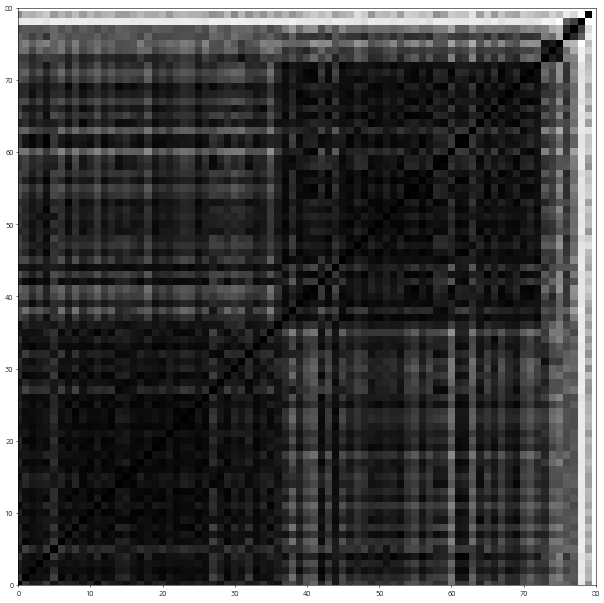

In [ ]:

#유사한 군집 확인
# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.2, sort=True)

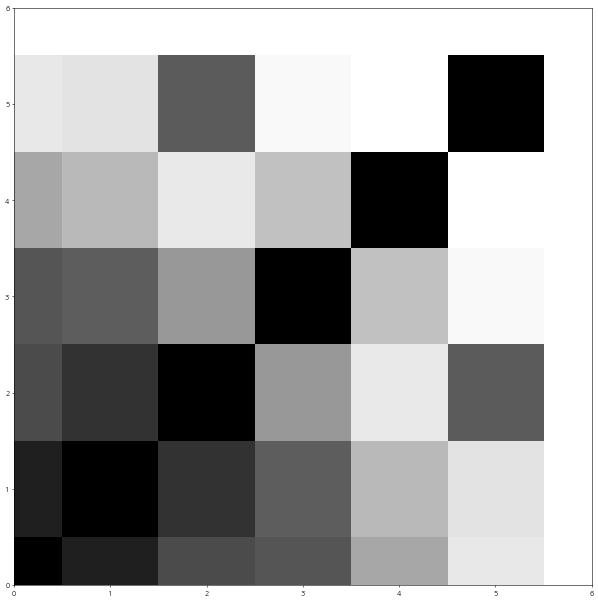

In [ ]:
#유사한 군집 병합
group_centers, groups = merge_close_clusters(centers, labels, max_dist=.17)
fig = visualize_pairwise_distance(group_centers, max_dist=.3, sort=True)

In [ ]:
group_list =[]
for group in groups:
  group_list.append(group)
  print(group)

[19, 56, 20, 27, 57, 9, 30, 44, 52, 47, 54, 10, 12, 49, 67, 31, 28, 35, 66, 58, 11, 34, 39, 8, 68, 14, 78, 16, 79, 75, 61, 72, 6, 15, 46, 73, 77, 22, 70, 55, 53]
[17, 40, 63, 23, 7, 64, 5, 0, 18, 48, 71, 43, 60, 26, 41, 38, 33, 45, 36, 13, 74, 32, 59, 42, 2, 4, 37, 21, 24, 3, 29, 69, 62]
[50, 65]
[51, 25]
[76]
[1]


In [ ]:
#cos k-means로 할당된 1차 그룹 라벨링
df_al2['group_1'] =labels


#클러스터링 재 할당

def cluster_reduce(x):
    for i, group in enumerate(group_list):
        if x in group:
            return i

    return -1  # 그룹에 없는 값인 경우 -1 반환

df_al2['re_group'] = df_al2['group_1'].apply(cluster_reduce)
df_al2

,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_PY_CYCLE_CD,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권,CT_PY_PDmm,mean_AMTmm,group_1,re_group
0,2,2,7,1,1,1,0,0,0,2,-1.432027,5.485298,50,2
1,2,2,1,1,2,1,0,0,0,2,-1.012055,-0.031289,9,0
2,2,4,7,1,2,1,0,0,0,0,-1.180044,-0.019868,7,1
3,1,4,6,4,1,1,0,0,1,1,-1.432027,-0.099818,21,1
4,1,5,3,1,2,1,1,1,0,0,0.247863,-0.168347,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58422,1,3,6,4,1,1,0,0,1,1,-1.432027,-0.214034,48,1
58423,1,2,6,2,1,1,0,0,0,1,-1.432027,-0.224313,69,1
58424,1,2,6,4,1,1,0,0,1,1,-1.432027,-0.218602,48,1
58425,2,5,6,4,1,1,0,0,1,1,-1.432027,-0.216318,21,1


In [ ]:
df_al2['re_group'].value_counts()

re_group
0    32951
1    23428
2     1225
3      801
4       12
5       10
Name: count, dtype: int64

In [ ]:
corr_df = df_check.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,JOIN_SN,POL_SN,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권,re_group
JOIN_SN,1.00,-0.00,-0.01,0.01,-0.01,-0.00,0.00,0.00,0.00,0.00,-0.00,0.01,0.01,0.00,-0.00,-0.01
POL_SN,-0.00,1.00,0.01,-0.00,-0.00,0.00,0.01,0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.01,-0.00
GENDER,-0.01,0.01,1.00,0.01,-0.01,-0.02,-0.01,-0.00,-0.00,0.02,-0.01,-0.01,-0.03,-0.05,0.01,-0.03
AGE_GROUP,0.01,-0.00,0.01,1.00,0.01,-0.01,-0.03,0.02,-0.18,0.08,-0.12,0.05,-0.04,-0.12,0.01,-0.23
reduce_GBN_CD,-0.01,-0.00,-0.01,0.01,1.00,0.14,0.05,-0.04,-0.28,0.18,-0.00,-0.45,-0.29,0.11,-0.06,0.66
reduce_STAT_CD,-0.00,0.00,-0.02,-0.01,0.14,1.00,0.05,-0.05,-0.20,-0.02,0.02,-0.14,-0.10,0.06,-0.03,0.08
CT_CHNL_CD,0.00,0.01,-0.01,-0.03,0.05,0.05,1.00,-0.03,-0.06,-0.02,0.03,-0.00,0.00,0.02,-0.01,0.00
CT_PY_CYCLE_CD,0.00,0.00,-0.00,0.02,-0.04,-0.05,-0.03,1.00,0.04,-0.06,-0.02,0.04,0.03,-0.01,0.02,0.03
CT_PY_PD,0.00,-0.01,-0.00,-0.18,-0.28,-0.20,-0.06,0.04,1.00,-0.18,0.12,0.23,0.25,0.12,-0.06,0.10
mean_AMT,0.00,-0.00,0.02,0.08,0.18,-0.02,-0.02,-0.06,-0.18,1.00,0.08,-0.19,-0.16,-0.11,0.12,0.34


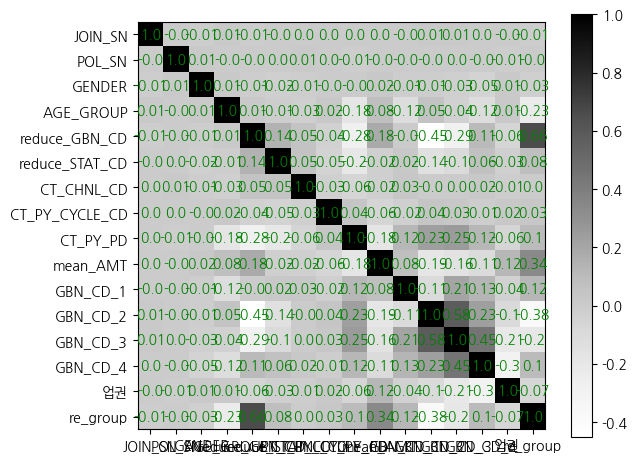

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(corr_df, cmap='Greys')

# Color Bar
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))

ax.set_xticklabels(corr_df.columns)
ax.set_yticklabels(corr_df.columns)

for x in range(len(corr_df.columns)):
    for y in range(len(corr_df.index)):
        ax.text(y, x, corr_df.iloc[y, x], ha='center', va='center', color='g')

fig.tight_layout()
plt.show()

# 데이터 분류 확인 작업 시작

## 1. 확인용 데이터프레임에 할당된 재그룹 라벨링

In [ ]:
#cos k-means로 할당된 1차 그룹 라벨링
df_check['group_1'] =labels


#클러스터링 재 할당

def cluster_reduce(x):
    for i, group in enumerate(group_list):
        if x in group:
            return i

    return -1  # 그룹에 없는 값인 경우 -1 반환

df_check['re_group'] = df_check['group_1'].apply(cluster_reduce)
df_check

,JOIN_SN,POL_SN,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권,group_1,re_group
0,15110,2197182,2,2,7,1,4,1,0,5000.0,1,0,0,0,2,50,2
1,56423,254040,2,2,1,1,1,2,5,170.0,1,0,0,0,2,9,0
2,1659127,5420542,2,4,7,1,5,2,3,180.0,1,0,0,0,0,7,1
3,817293,5884271,1,4,6,4,7,1,0,110.0,1,0,0,1,1,21,1
4,798115,6197631,1,5,3,1,1,2,20,50.0,1,1,1,0,0,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58422,1892963,8605817,1,3,6,4,7,1,0,10.0,1,0,0,1,1,48,1
58423,1898196,5285028,1,2,6,2,99,1,0,1.0,1,0,0,0,1,69,1
58424,1942749,6650657,1,2,6,4,7,1,0,6.0,1,0,0,1,1,48,1
58425,1946706,8536828,2,5,6,4,7,1,0,8.0,1,0,0,1,1,21,1


## 데이터 확인에 불필요한 컬럼 삭제 => group_1,

In [ ]:
df_check.drop(columns =('group_1'), axis=1, inplace=True)

## re_group 구성 0-30922 / 1-22505/ 2-4994 / 3-6(개)
- 궁금증 1. 6개인건 뭘까? 혹시 저번에 보험료납입금액이 매우컷던 사람들? => 아님/ 그사람들은 가장 많은 0번그룹으로 할당됨.

- 궁금증 2. 나뉜 요소가 업권코드의 비율과 흡사하다. 매칭률을 확인해보자 (? 의문사항? 혹시 이렇게확인하면 업권코드가 target변수가 된 지도학습같아지는데 ?)=> 개수는 차이가 나지만 군집의 개수 자체에서 차이가 나기 때문에 분포의 모양을 확인해봤으나 비슷함


- 궁금증 3. 어떤 컬럼의 영향으로 인해 이렇게 나뉜걸까 확인해보자 => 소현튜터님이 확인방법으로 말해주신 그룹별 count plot을 이용
=> 각 컬럼의 분포를 count/hist확인해본 결과 각 군집별 컬럼의 분표형태가 매우 비슷하다.



무엇으로 나뉜건지 잘 알수가 없다.

### 확인 1. 3번 그룹의 6명의 사람들은 어떤기준으로 나뉜것인가.

In [ ]:
# 3번 그룹 사람들만 추출
df_check[df_check['re_group']==3]

,JOIN_SN,POL_SN,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권,re_group
103,682253,166440,2,6,7,1,1,2,99,240.000000,1,0,0,0,2,3
141,827206,9670739,2,4,1,1,1,2,99,270.000000,1,0,0,0,2,3
237,1688566,2978751,1,4,7,2,1,2,99,180.000000,1,0,0,0,2,3
368,162506,8713945,1,3,2,1,1,2,67,31.500000,1,0,0,1,1,3
467,859461,1344705,2,4,1,1,1,2,99,140.000000,1,0,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57845,788353,8811757,1,3,2,1,6,2,70,50.000000,1,0,1,0,1,3
57846,1450487,7484797,1,3,2,1,1,2,68,44.666667,1,1,1,1,1,3
57886,1801671,8861913,1,4,7,1,1,2,99,90.000000,1,0,0,0,2,3
57951,1084857,5921214,2,5,7,1,3,2,99,400.000000,1,0,0,0,2,3


### 값이 크던 사람들은 어느그룹으로 배정이 된걸까 => 가장 개수가 많은 0번 그룹에 들어갔다

In [ ]:
df_check[df_check['mean_AMT']>=6000]

,JOIN_SN,POL_SN,GENDER,AGE_GROUP,reduce_GBN_CD,reduce_STAT_CD,CT_CHNL_CD,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,업권,re_group
5897,99474,2323093,2,7,7,1,4,3,2,60000.0,1,0,0,1,1,5
10679,1632303,9796439,2,6,7,2,4,3,2,60000.0,1,0,0,1,1,5
18772,1880517,9589980,2,7,7,1,4,3,2,60000.0,1,0,0,1,1,5
27880,1536048,1521730,1,6,3,1,4,3,3,12000.0,1,0,0,1,1,5
29951,704732,1311568,1,5,3,1,4,3,2,12000.0,1,0,0,1,1,5
50837,1766428,6288548,2,6,7,1,4,3,2,30000.5,1,0,0,0,1,5
52031,1951493,6883574,2,4,7,1,4,3,2,60000.0,1,0,0,1,1,5


In [ ]:
df_check.nunique()

JOIN_SN           22193
POL_SN            58427
GENDER                2
AGE_GROUP             9
reduce_GBN_CD         9
reduce_STAT_CD        4
CT_CHNL_CD            8
CT_PY_CYCLE_CD        4
CT_PY_PD             99
mean_AMT           1021
GBN_CD_1              2
GBN_CD_2              2
GBN_CD_3              2
GBN_CD_4              2
업권                    3
re_group              4
dtype: int64

- 그룹화

In [ ]:
grouped = df_check.groupby('re_group')

In [ ]:
#re_group 별로 특징을 알아보고 싶다.
#gender , age_group, reduce_GBN_CD, reduce_STAT_CD, CT_CHNL_CD, CYCLE_CD, MEAN_AMT, 업권 등등

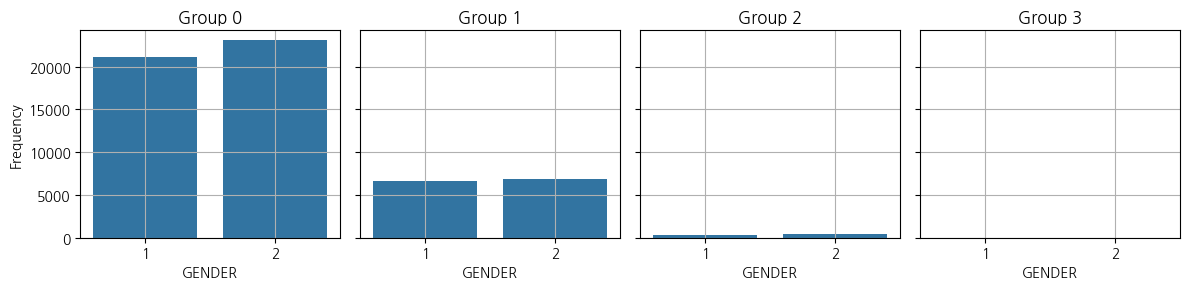

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3), sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='GENDER', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GENDER')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

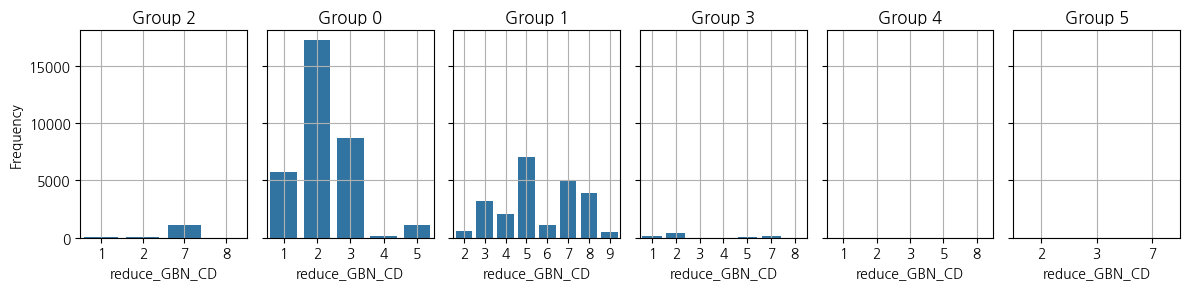

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='reduce_GBN_CD', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('reduce_GBN_CD')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

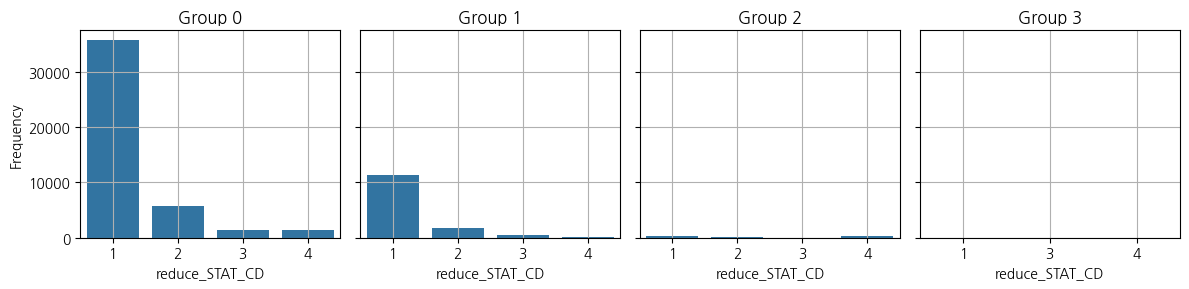

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='reduce_STAT_CD', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('reduce_STAT_CD')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

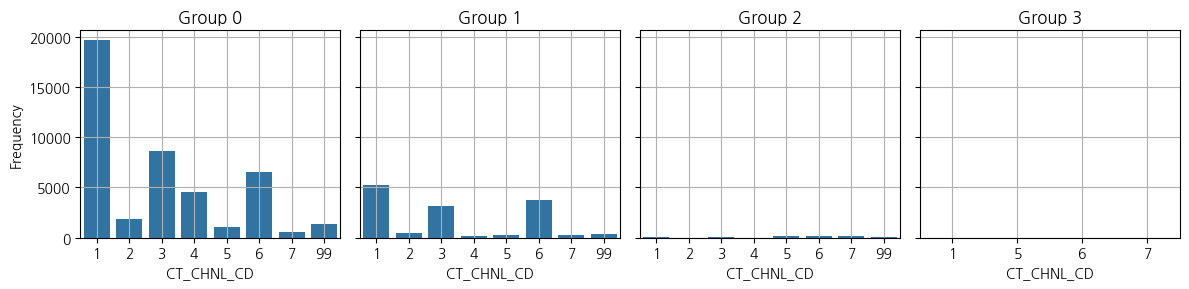

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3), sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='CT_CHNL_CD', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('CT_CHNL_CD')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

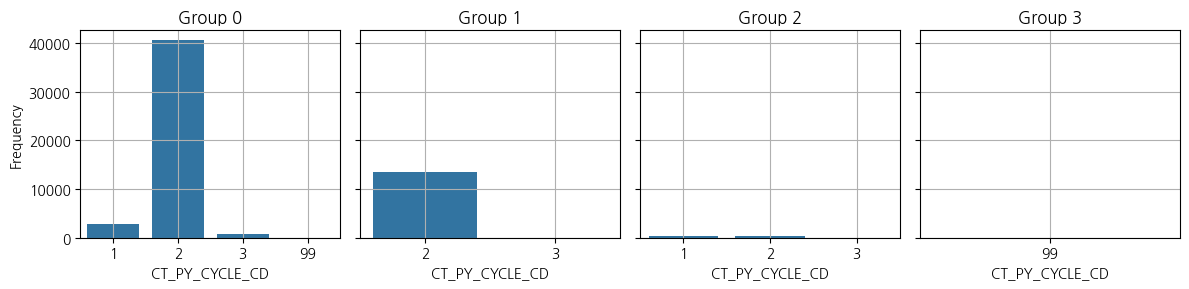

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='CT_PY_CYCLE_CD', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('CT_PY_CYCLE_CD')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

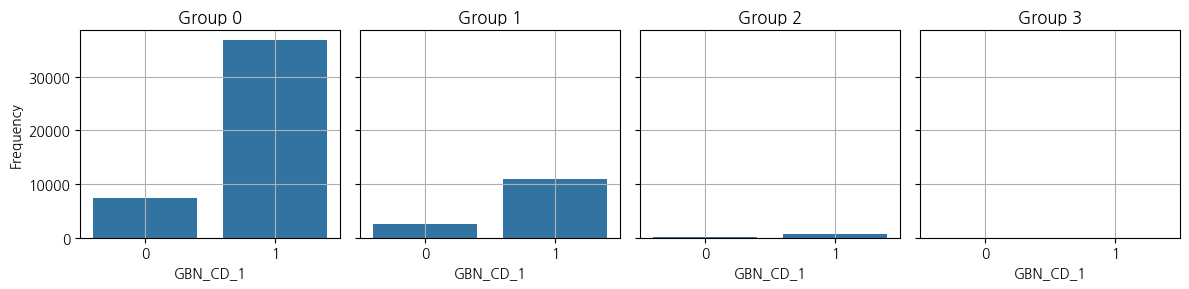

In [ ]:
#CT_PY_PD	mean_AMT	GBN_CD_1	GBN_CD_2	GBN_CD_3	GBN_CD_4	업권

import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_1', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_1')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

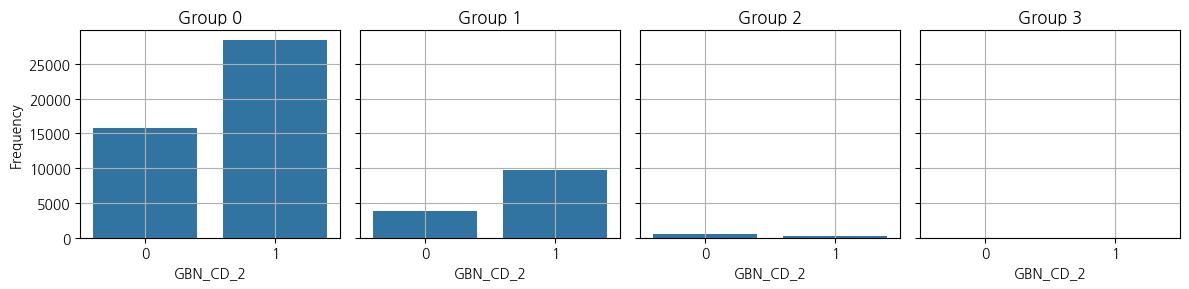

In [ ]:
#CT_PY_PD	mean_AMT	GBN_CD_1	GBN_CD_2	GBN_CD_3	GBN_CD_4	업권

import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_2', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_2')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

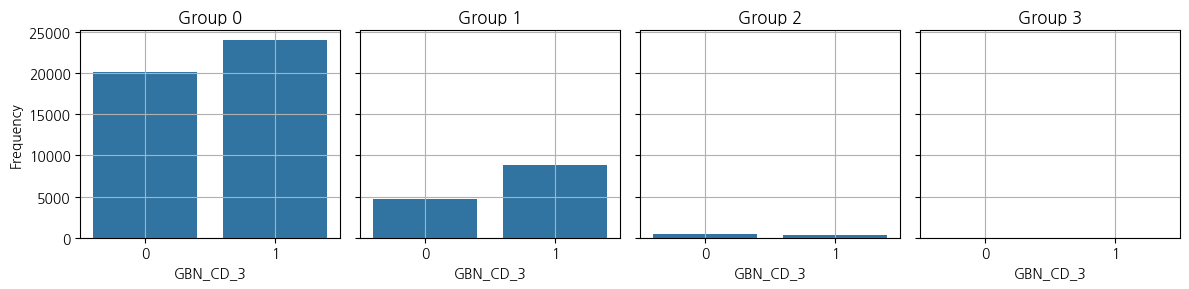

In [ ]:
#CT_PY_PD	mean_AMT	GBN_CD_1	GBN_CD_2	GBN_CD_3	GBN_CD_4	업권

import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_3', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_3')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

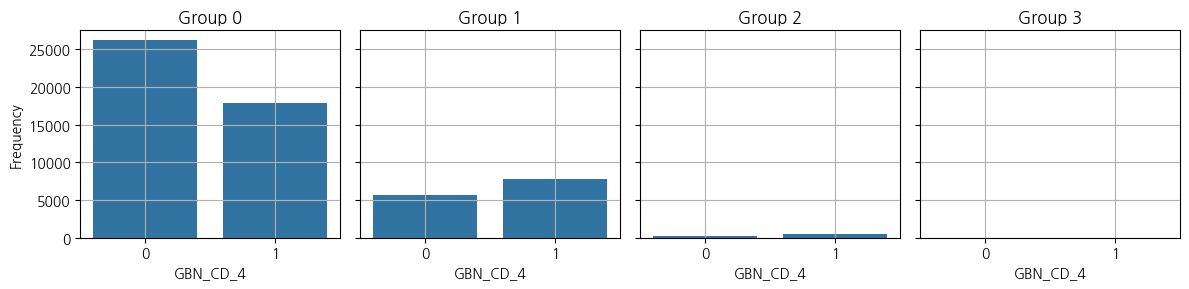

In [ ]:
#CT_PY_PD	mean_AMT	GBN_CD_1	GBN_CD_2	GBN_CD_3	GBN_CD_4	업권

import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_4', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_4')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

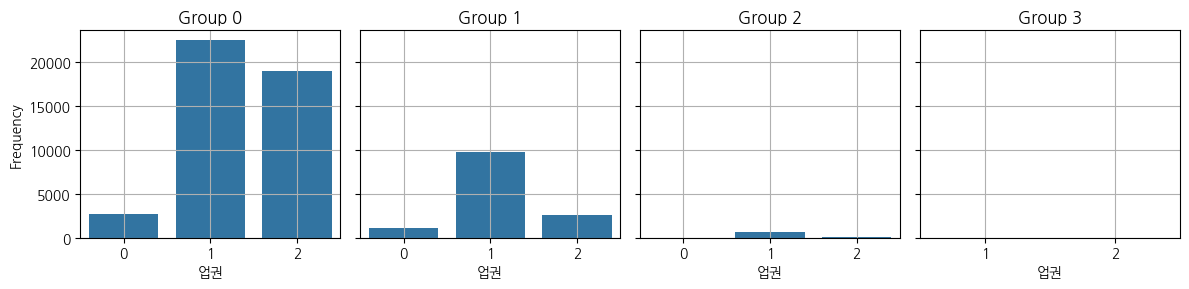

In [ ]:
#CT_PY_PD	mean_AMT	GBN_CD_1	GBN_CD_2	GBN_CD_3	GBN_CD_4	업권

import seaborn as sns
import matplotlib.pyplot as plt

# 're_group'의 유니크한 값을 찾기
unique_group = df_check['re_group'].dropna().unique()  # nan 값 제거

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == group]

    # countplot 그리기
    sns.countplot(x='업권', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('업권')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

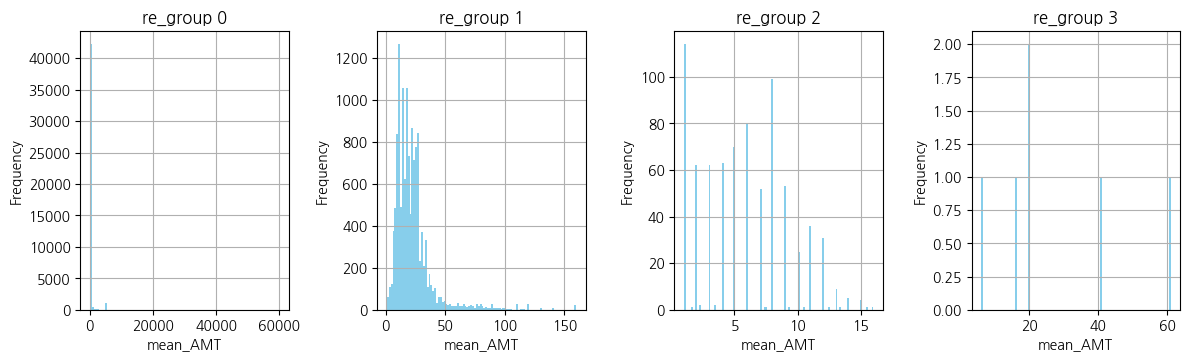

In [ ]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = df_check['re_group'].unique()

# subplots와 subplot은 다른 것!!!


#전체 크기를 조절하는 코드
#있어도 되고 없어도된다.
plt.figure(figsize=(12, 10))


# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['mean_AMT'], bins=100, color='skyblue')
    plt.title(f're_group {cycle}')
    plt.xlabel('mean_AMT')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

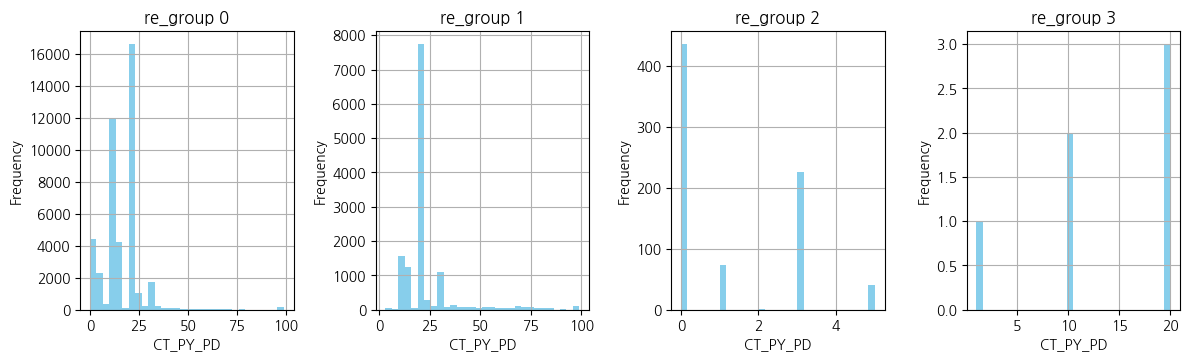

In [ ]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = df_check['re_group'].unique()

# subplots와 subplot은 다른 것!!!


#전체 크기를 조절하는 코드
#있어도 되고 없어도된다.
plt.figure(figsize=(12, 10))


# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = df_check[df_check['re_group'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['CT_PY_PD'], bins=30, color='skyblue')
    plt.title(f're_group {cycle}')
    plt.xlabel('CT_PY_PD')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

# gower 방법 시도

In [ ]:
import gower
from sklearn.cluster import DBSCAN

dist_matrix = gower.gower_matrix(df_al)
db = DBSCAN(eps = 0.3, min_samples = 10, metric = "precomputed").fit(dist_matrix)
labels = db.labels_